In [1]:
#! /usr/bin/python3
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec
import sys, os, subprocess
import json as json
from tqdm import tqdm
import pandas as pd
import argparse
from pathlib import Path
import seaborn as sns
import matplotlib.tri as tri
sys.path.append("../")
from libraries.functions import *
from libraries.particles import *
import plotly.graph_objects as go

In [2]:
def get_trench_position(p, threshold = 2.7e7):
    if {"opc"}.issubset(p.columns):
        tr =  p.loc[(p['Points:0']< threshold) & (p["opc"] > 0.3) & (p["Points:1"] >=  p["Points:1"].max() - 2.e3),'Points:0'].min()
    else:
        tr =  p.loc[(p['Points:0']< threshold) & (p['op'] > 0.3) & (p["Points:1"] >=  p["Points:1"].max() - 2.e3),'Points:0'].min()
    return tr

In [3]:
data_dir = "/home/vturino/PhD/projects/exhumation/gz_outputs/"
output_dir = "kinematic_mu0.025_upto35Myr"

In [13]:
data = pd.read_parquet(f'{data_dir}{output_dir}/particles/full.1.gzip')
data_fields = pd.read_parquet(f'{data_dir}{output_dir}/fields/full.1.gzip')
pts = get_points_with_y_in(data, 15.e3, 2.e3, ymax = data["Points:1"].max())
trench= get_trench_position(pts)
tr = 1e-2

filcompo = (data["oc"] > tr) | (data["ecl"] > tr) | (data["sed"] > tr) | (data["opc"] > tr)
compopart = data[filcompo]


data_fields["sed"][data_fields["Points:1"] < 800.e3] = 0
data_fields["ecl"][data_fields["Points:1"] < 750.e3] = 0

data_fields["oc"][data_fields["oc"] > 0.5] = 1
data_fields["oc"][data_fields["oc"] <= 0.5] = 0
data_fields["sed"][data_fields["sed"] > 0.5] = 1
data_fields["sed"][data_fields["sed"] <= 0.5] = 0
data_fields["opc"][data_fields["opc"] > 0.5] = 1
data_fields["opc"][data_fields["opc"] <= 0.5] = 0
data_fields["op"][data_fields["op"] > 0.5] = 1
data_fields["op"][data_fields["op"] <= 0.5] = 0
data_fields["ecl"][data_fields["ecl"] > 0.5] = 1
data_fields["ecl"][data_fields["ecl"] <= 0.5] = 0

data_fields["sed"] = 5*data_fields["sed"]
data_fields["opc"] = 3*data_fields["opc"]
data_fields["op"] = 4*data_fields["op"]
data_fields["ecl"] = 2*data_fields["ecl"]

data_fields["comp"] = data_fields["op"]+data_fields["opc"]+data_fields["sed"]+data_fields["oc"]+data_fields["ecl"]


xmin_plot = trench -100.e3
xmax_plot = trench + 200.e3
ymin_plot = 800.e3
ymax_plot = 900.e3

x = data_fields["Points:0"].to_numpy()/1.e3
y = (ymax_plot - data_fields["Points:1"].to_numpy())/1.e3

triang = tri.Triangulation(x, y)
colors = matplotlib.colormaps['Accent'].resampled(6)
colors.set_bad('white')

# plot only triangles with sidelength smaller some max_radius
max_radius = 10
triangles = triang.triangles

# Mask off unwanted triangles.  
xtri = x[triangles] - np.roll(x[triangles], 1, axis=1)
ytri = y[triangles] - np.roll(y[triangles], 1, axis=1)
maxi = np.max(np.sqrt(xtri**2 + ytri**2), axis=1)
triang.set_mask(np.logical_and(maxi > max_radius, y[triangles][:,1] < 90.))


# row = exhumed_data[exhumed_data['time'] == t]
particle = get_incoming_particles(compopart, 1, trench - 50.e3, 3)
idx = particle.id




In [42]:
idx[0]

4951559.0

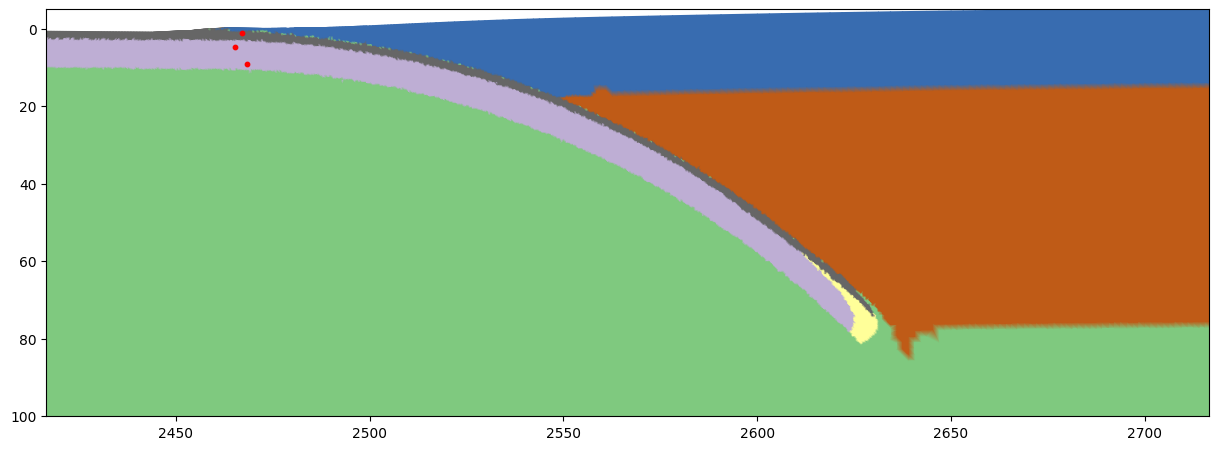

In [30]:
plt.figure(figsize=(15,7))
plt.tripcolor(triang, data_fields["comp"], cmap=colors, shading='gouraud', vmax=5, vmin=0)
plt.scatter (particle["Points:0"]/1e3, (ymax_plot-particle["Points:1"])/1e3, c = "red", s = 10, zorder = 20)
# plt.colorbar(orientation='horizontal', label='Composition')
plt.ylim([(ymax_plot-ymin_plot)/1.e3,-5])
plt.xlim([xmin_plot/1.e3,xmax_plot/1.e3])
plt.gca().set_aspect('equal')


In [47]:
import seaborn as sns

p1 = pd.DataFrame(columns=["Points:0", "Points:1", "oc", "sed", "ecl"], index = range(0, 30))
p2 = pd.DataFrame(columns=["Points:0", "Points:1", "oc", "sed", "ecl"], index = range(0, 30))
p3 = pd.DataFrame(columns=["Points:0", "Points:1", "oc", "sed", "ecl"], index = range(0, 30))

p = np.array([p1, p2, p3])

for j in range(len(particle)):
    for i in range(0, 30):
        data = pd.read_parquet(f'{data_dir}{output_dir}/particles/full.{i}.gzip')
        particle.iloc[j] = data[data["id"].isin(particle.id.iloc[j])]
        # p.iloc[i]["Points:0"] = particle["Points:0"].values[0]/1e3
        # p.iloc[i]["Points:1"] = particle["Points:1"].values[0]/1e3
        # p.iloc[i]["oc"] = particle["oc"].values[0]


TypeError: only list-like objects are allowed to be passed to isin(), you passed a [float32]

<Axes: xlabel='Points:0', ylabel='Points:1'>

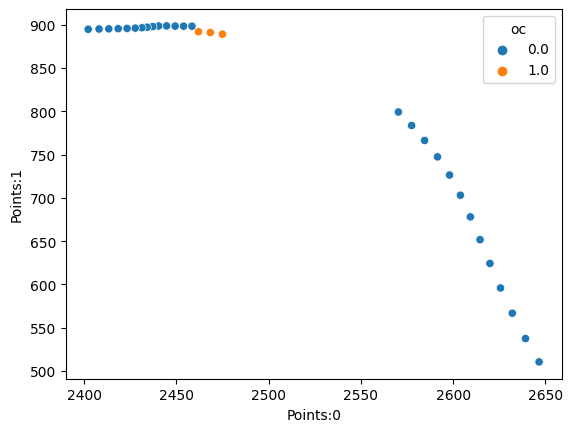

<Axes: xlabel='Points:0', ylabel='Points:1'>

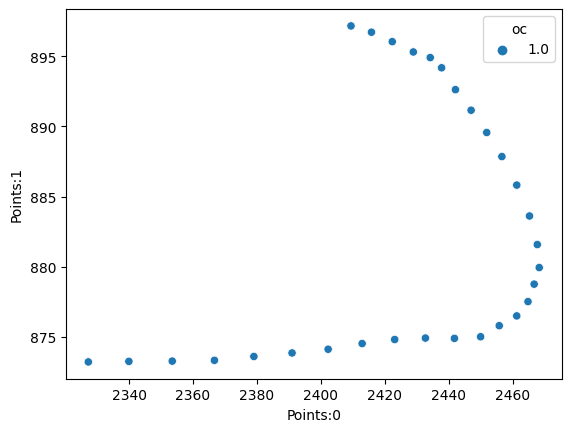

In [19]:
sns.scatterplot(data = p, x = p["Points:0"], y = p["Points:1"], hue = "oc")

(800.0, 905.0)

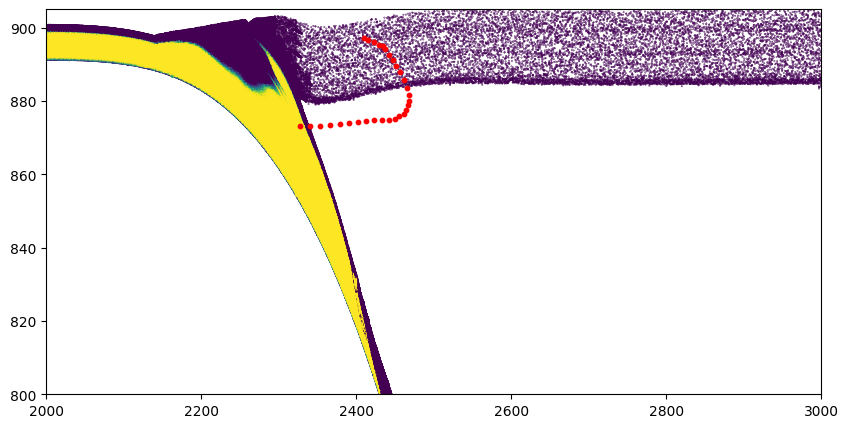

In [22]:
data = pd.read_parquet(f'{data_dir}{output_dir}/particles/full.29.gzip')
pts = get_points_with_y_in(data, 15.e3, 2.e3, ymax = data["Points:1"].max())
trench= get_trench_position(pts)
tr = 1e-2

filcompo = (data["oc"] > tr) | (data["ecl"] > tr) | (data["sed"] > tr) | (data["opc"] > tr)
compopart = data[filcompo]

plt.figure(figsize=(10,5))
plt.scatter(compopart["Points:0"]/1e3, compopart["Points:1"]/1e3, c = compopart["oc"], cmap = "viridis", s = 0.1)
plt.scatter (p["Points:0"], p["Points:1"], c = "red", s = 10, zorder = 10)
plt.xlim(2000, 3000) 
plt.ylim(800, 905)

In [47]:
plt_dir = "/home/vturino/PhD/projects/exhumation/plots/single_models"
modplot_dir = "kinematic_mu0.025_upto35Myr"
pltloc = f"{plt_dir}/{modplot_dir}/scatters"

/tmp/ipykernel_708223/1512301331.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,5))


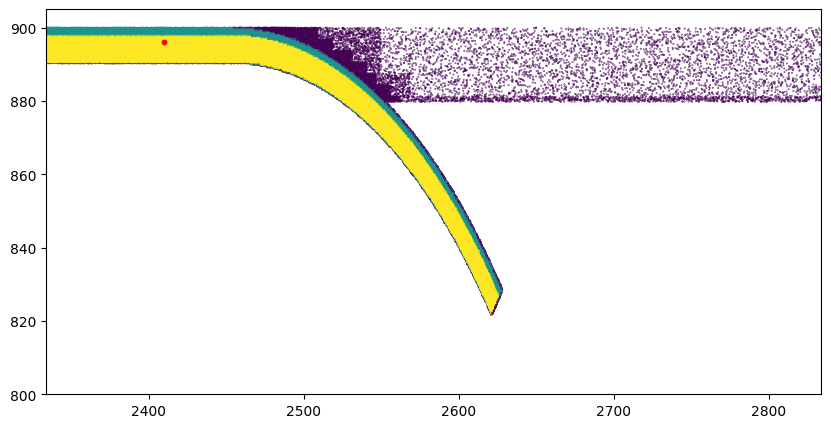

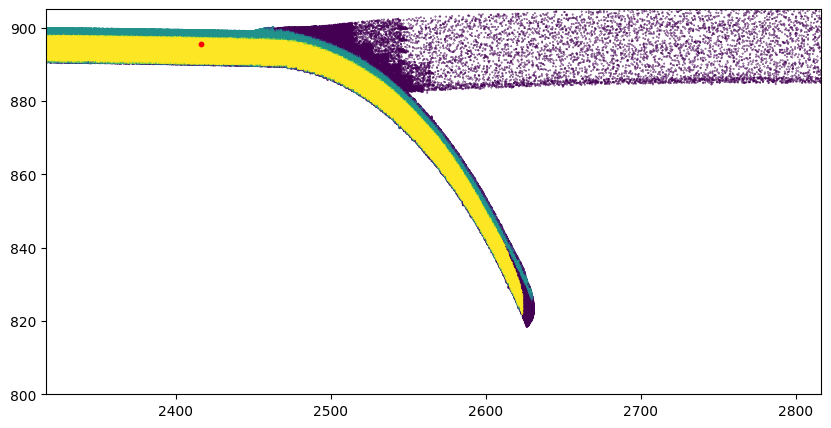

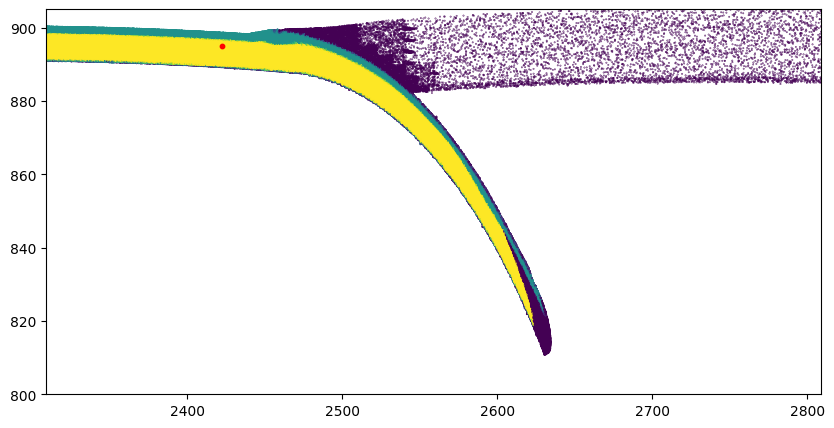

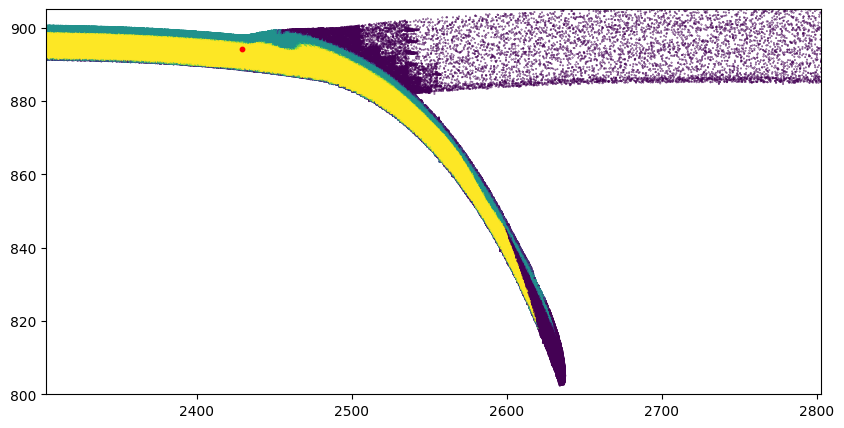

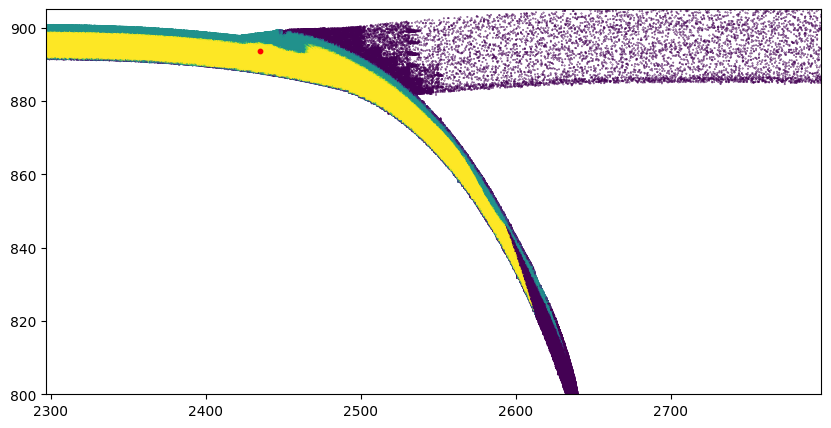

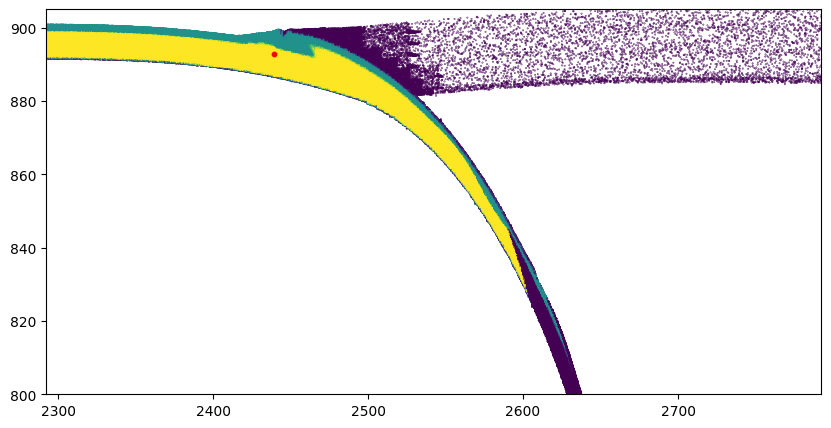

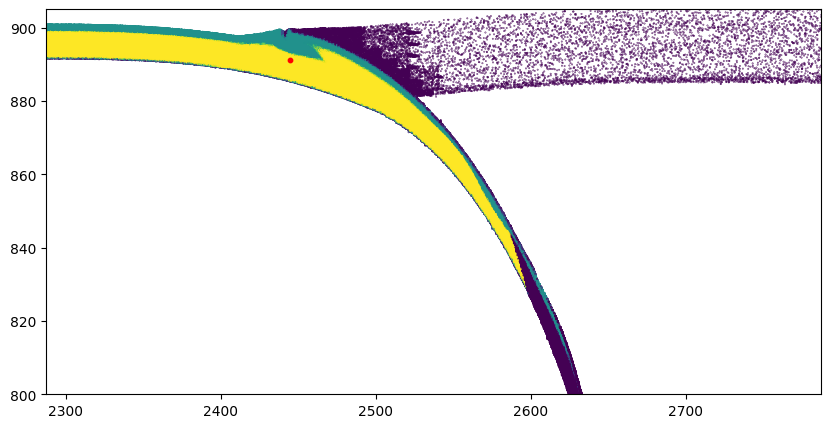

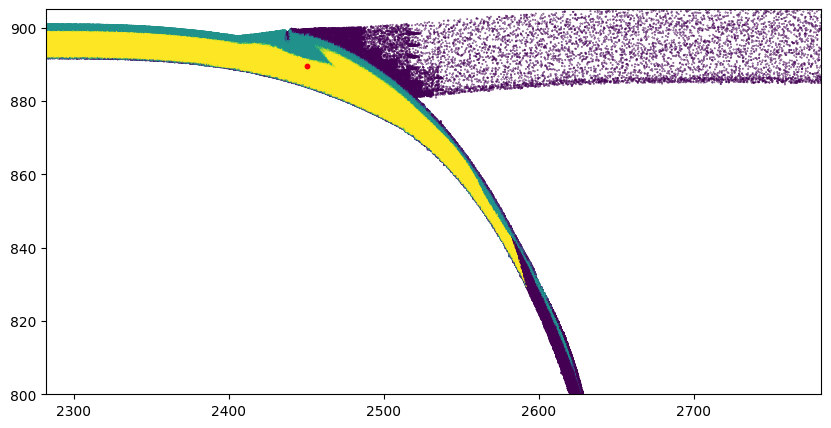

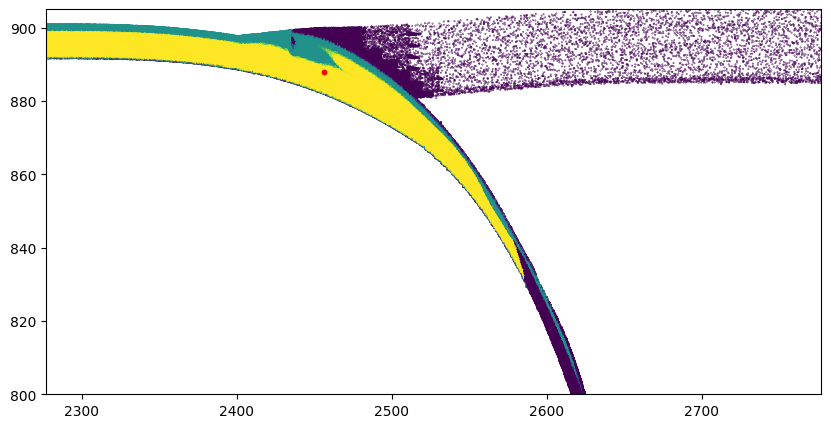

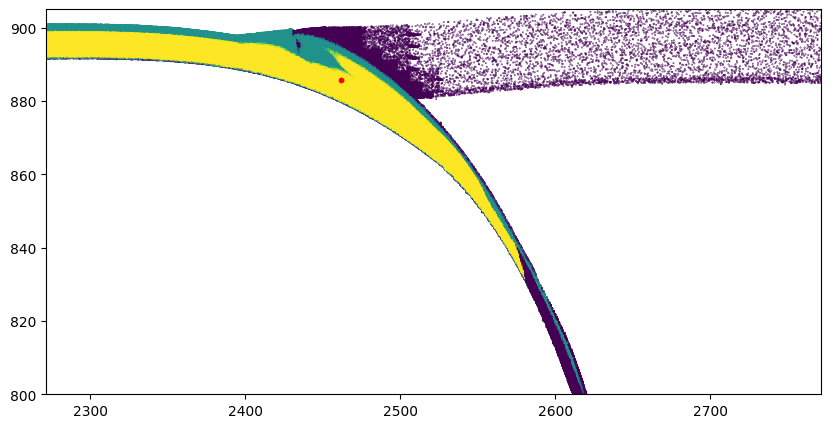

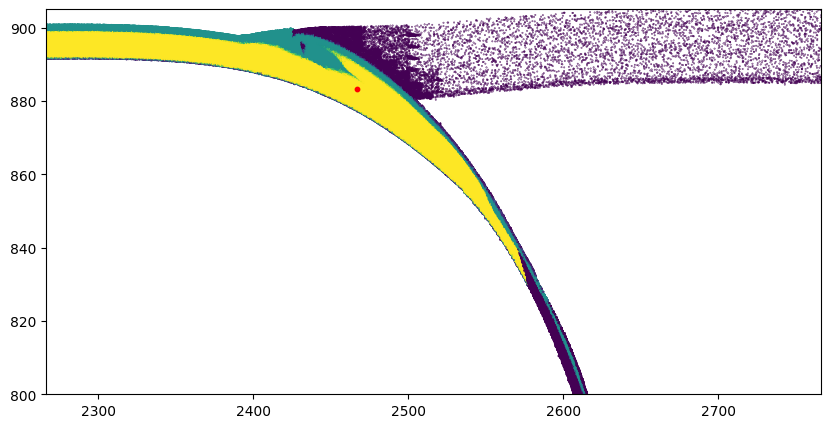

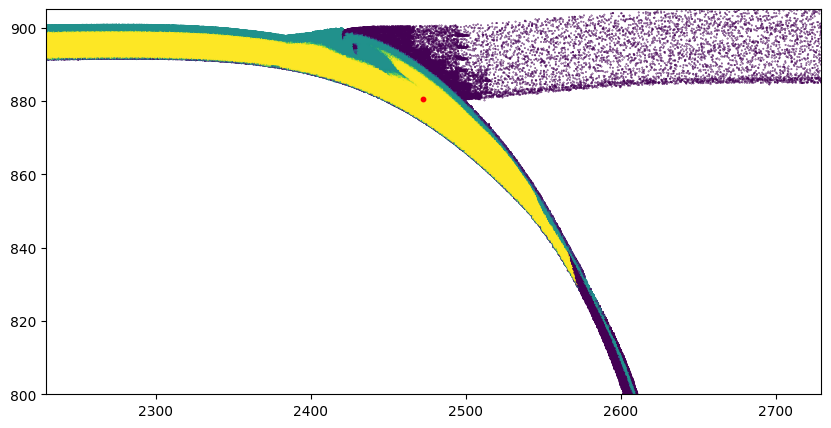

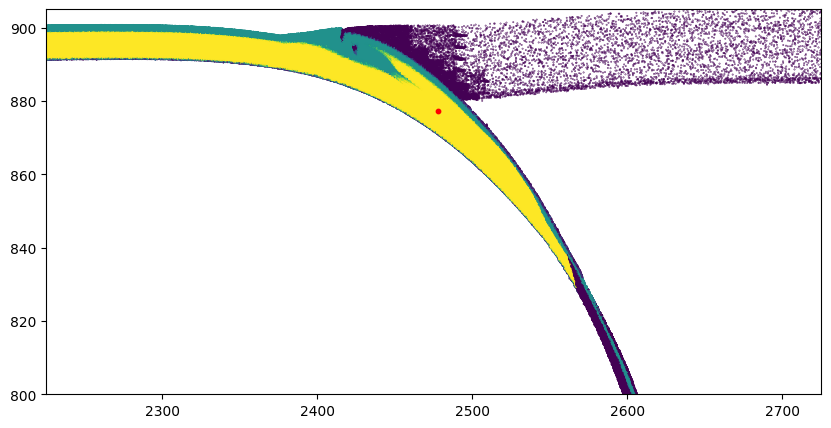

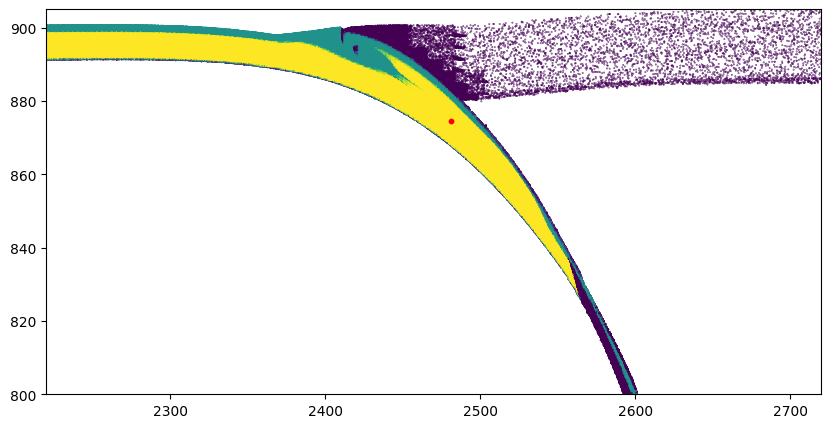

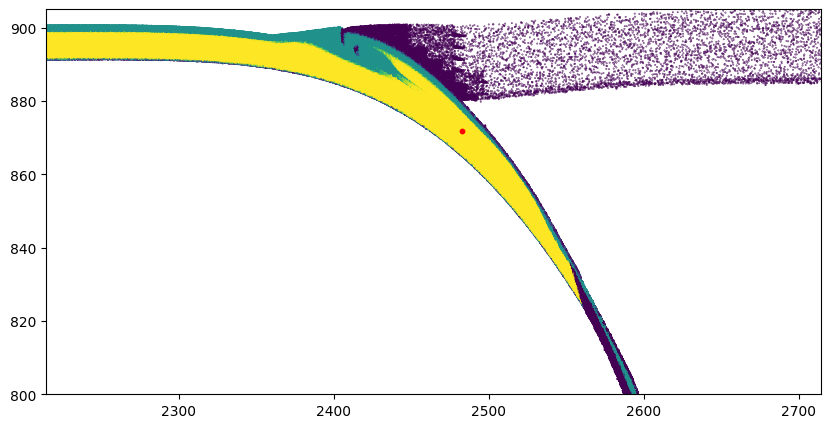

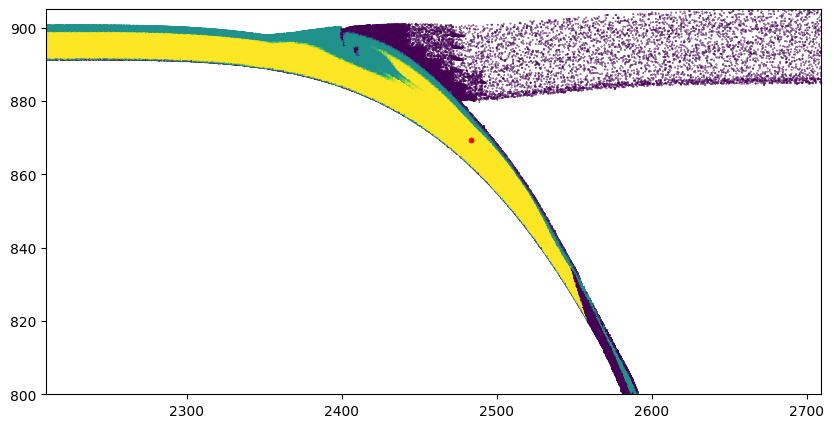

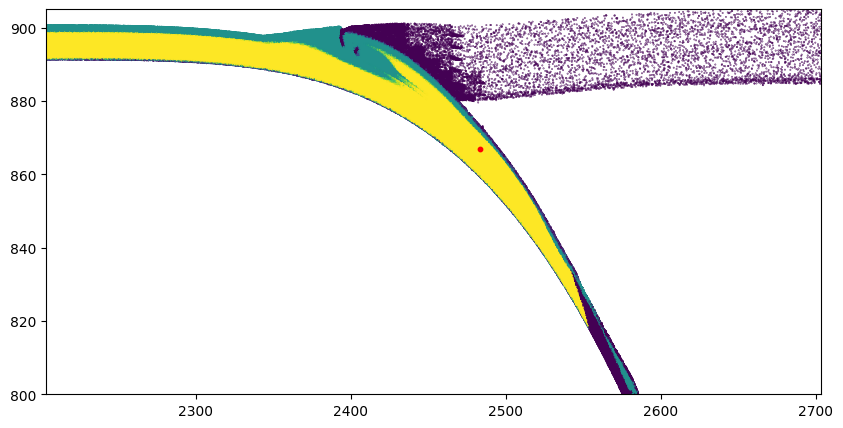

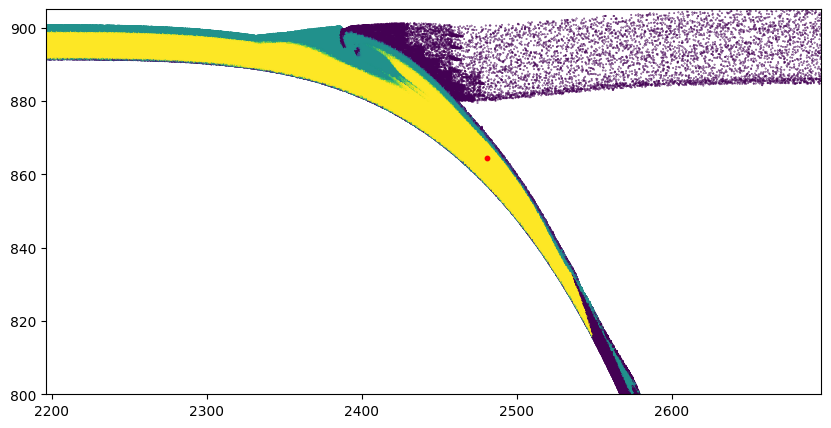

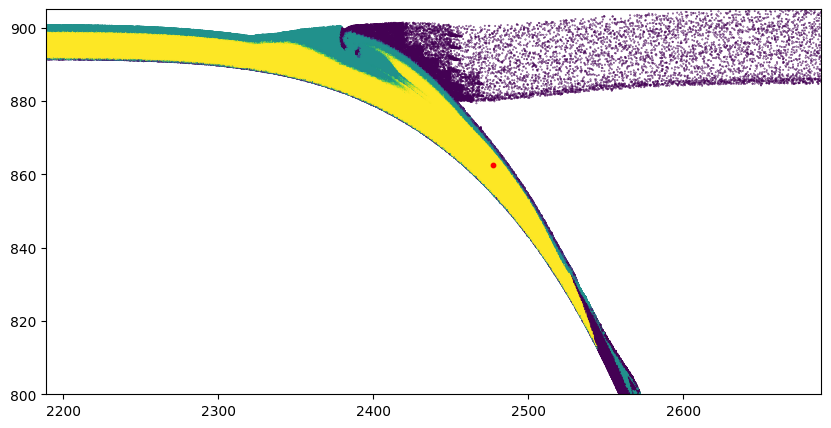

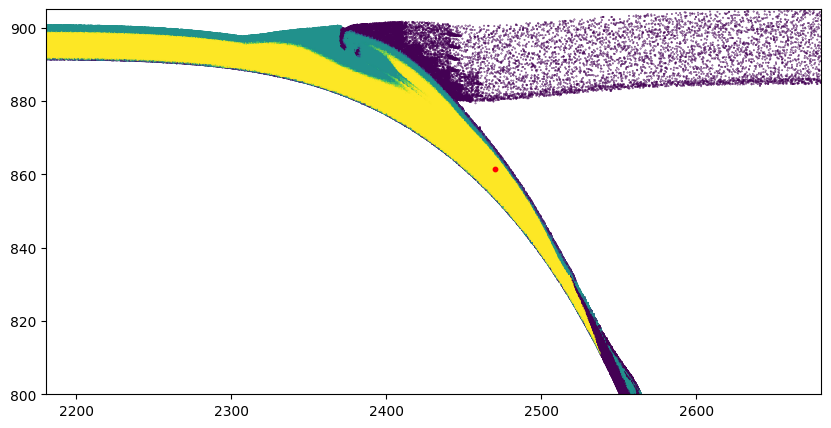

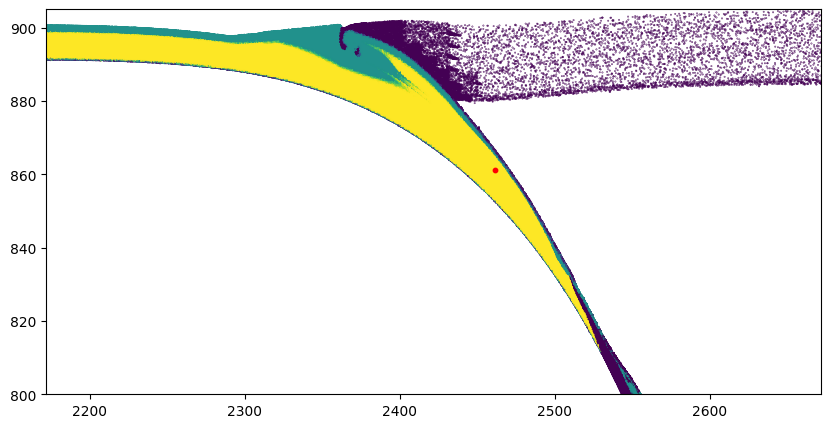

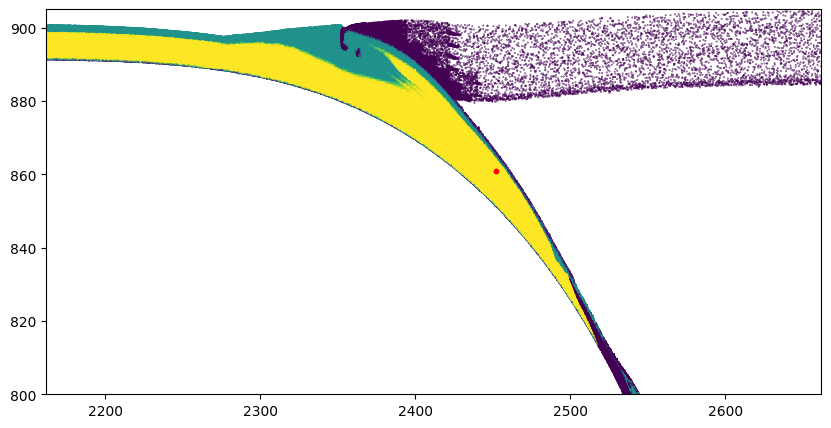

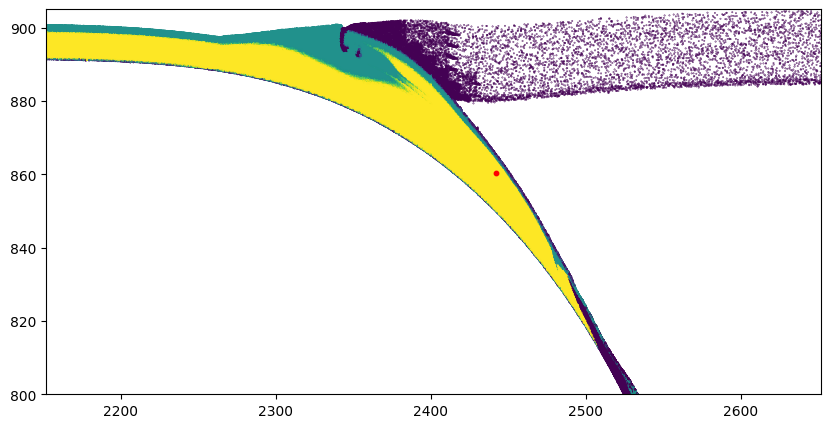

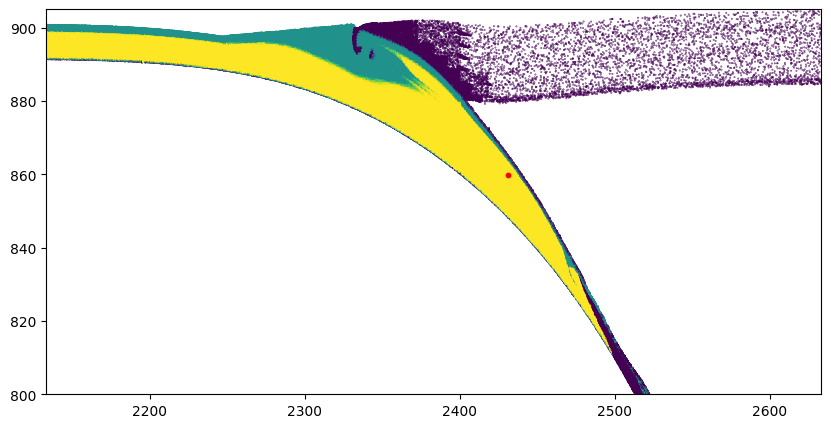

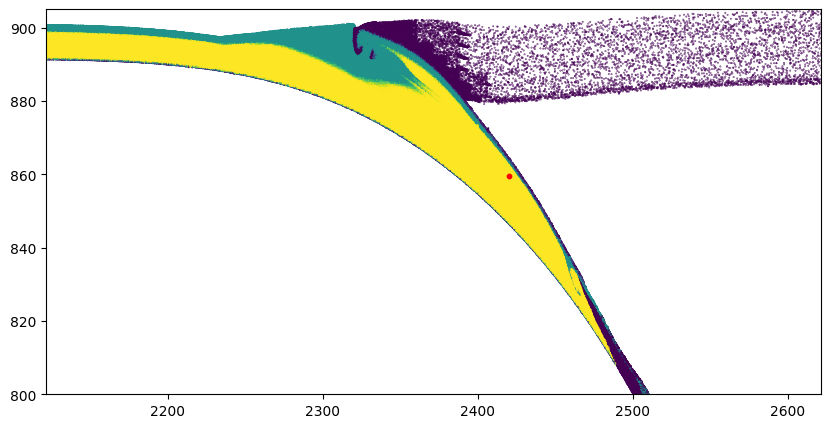

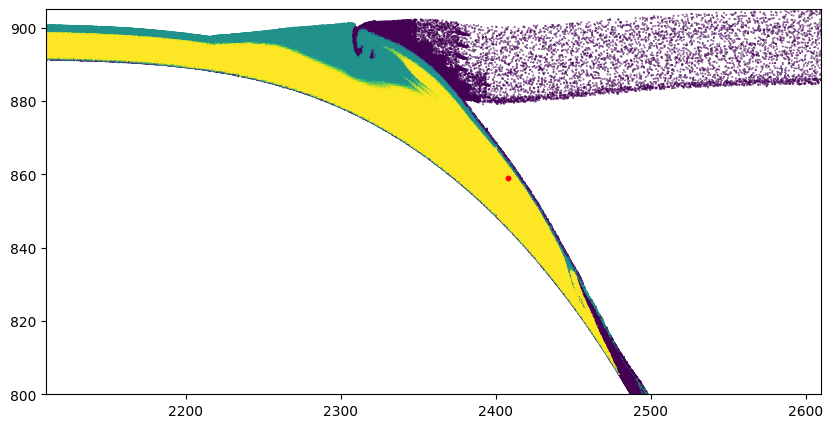

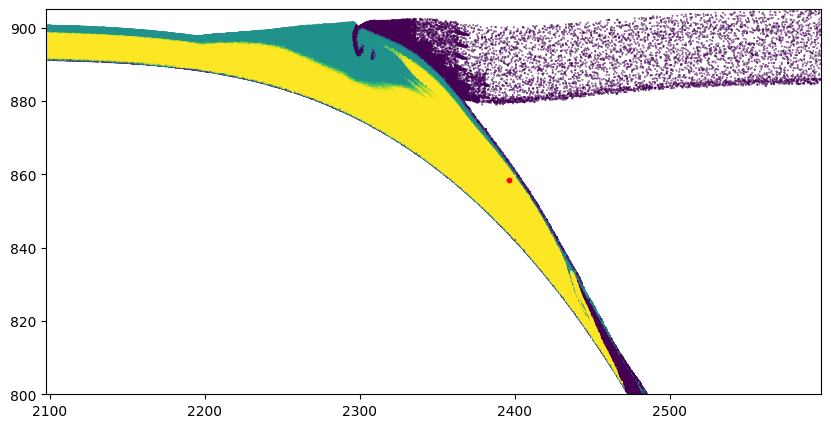

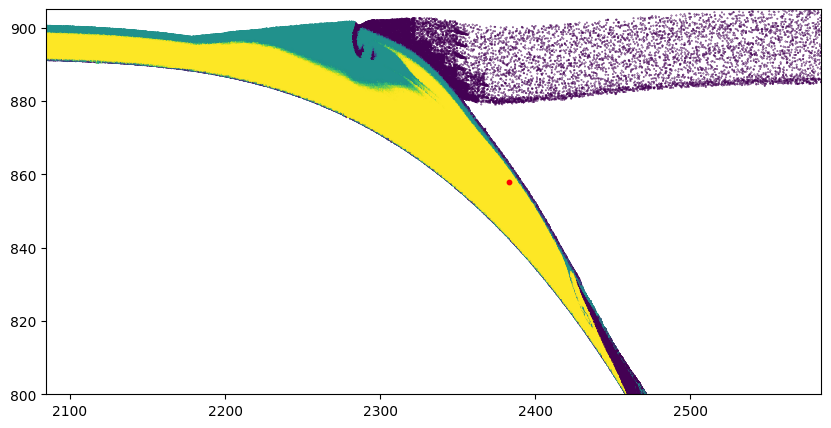

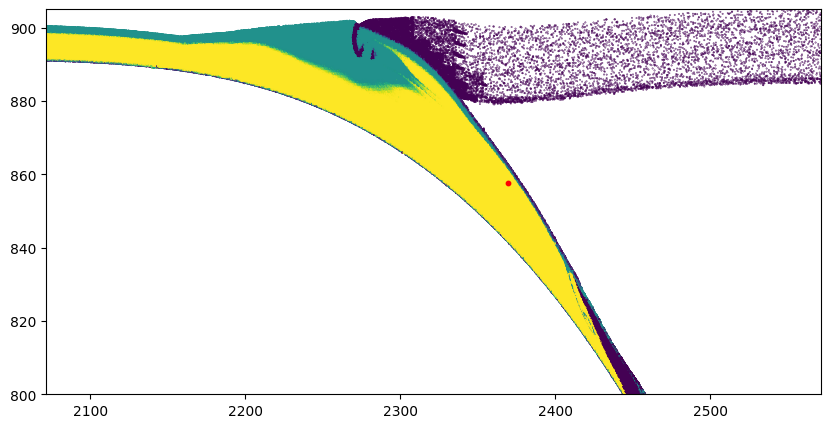

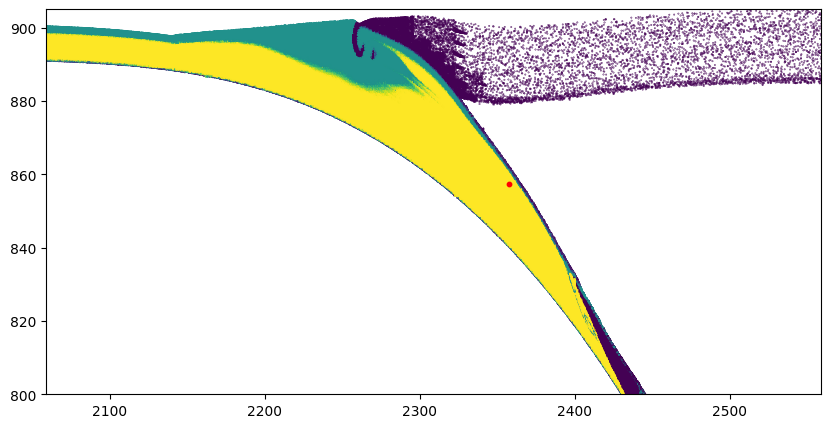

In [58]:
for i in range(0, 30):
    data = pd.read_parquet(f'{data_dir}{output_dir}/particles/full.{i}.gzip')
    pts = get_points_with_y_in(data, 15.e3, 2.e3, ymax = data["Points:1"].max())
    trench = get_trench_position(pts)
    filcompo = (data["oc"] > tr) | (data["ecl"] > tr) | (data["sed"] > tr) | (data["opc"] > tr)
    compopart = data[filcompo]
    particle = data[data["id"].isin(idx)]

    plt.figure(figsize=(10,5))
    plt.scatter(compopart["Points:0"]/1e3, compopart["Points:1"]/1e3, c = 2*compopart["oc"]+compopart["sed"], cmap = "viridis", s = 0.1)
    plt.scatter (particle["Points:0"]/1e3, particle["Points:1"]/1e3, c = "red", s = 10, zorder = 10)
    plt.xlim(trench/1e3 - 200, trench/1e3 + 300) 
    plt.ylim(800, 905)
    plt.savefig(f"{pltloc}/particle_t_{i}.png")

In [38]:
x_trench = np.zeros(30)

for i in range(0, 30):
    data = pd.read_parquet(f'{data_dir}{output_dir}/particles/full.{i}.gzip')
    pts = get_points_with_y_in(data, 15.e3, 2.e3, ymax = data["Points:1"].max())
    x_trench[i]= get_trench_position(pts)

In [44]:
p["time"] = np.arange(0, 30)

Points:0    Points:1   oc  time
0   2409.41225  897.159188  1.0     0
1   2415.81525  896.712125  1.0     1
2     2422.322    896.0395  1.0     2
3   2428.90125    895.3045  1.0     3
4       2434.2  894.903063  1.0     4
5    2437.7535    894.1775  1.0     5
6   2442.08175   892.62075  1.0     6
7    2446.9835  891.155625  1.0     7
8    2451.8685     889.568  1.0     8
9      2456.61  887.854687  1.0     9
10    2461.266  885.824062  1.0    10
11    2465.252  883.623062  1.0    11
12   2467.6915    881.5885  1.0    12
13  2468.29275  879.949875  1.0    13
14  2466.70075  878.769375  1.0    14
15     2464.78    877.5245  1.0    15
16  2461.25525  876.506875  1.0    16
17    2455.787  875.810875  1.0    17
18  2449.95725  875.023375  1.0    18
19    2441.767  874.907687  1.0    19
20   2432.6895  874.928562  1.0    20
21  2423.07925  874.825875  1.0    21
22   2412.8985   874.53775  1.0    22
23  2402.26075  874.132625  1.0    23
24  2390.97425  873.868313  1.0    24
25  2379.03225   873.61675  1.0    25
26  2366.69275  873.343625  1.0    26
27  2353.49875  873.288063  1.0    27
28  2339.93775  873.267563  1.0    28
29  2327.24875  873.229875  1.0    29

<Axes: xlabel='Points:0', ylabel='Points:1'>

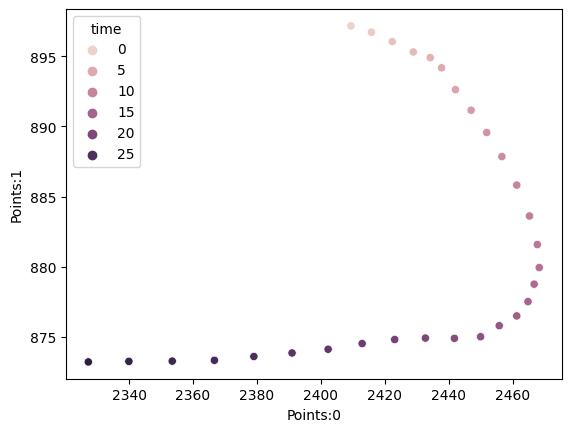

In [46]:
sns.scatterplot(data = p, x = p["Points:0"], y = p["Points:1"], hue="time")